# Generative adversarial network (GAN) 

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio 
from IPython.display import HTML
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid

In [2]:
# Create folders
if not os.path.exists('./checkpoint'):
    os.mkdir('./checkpoint')
    
if not os.path.exists('./dataset'):
    os.mkdir('./dataset')
    
if not os.path.exists('./img'):
    os.mkdir('./img')
    
if not os.path.exists('./img/real'):
    os.mkdir('./img/real')

if not os.path.exists('./img/fake'):
    os.mkdir('./img/fake')

In [3]:
# visualize the first image from the torch tensor
def vis_image(image):
    plt.imshow(image[0].detach().cpu().numpy(),cmap='gray')
    plt.show()

In [4]:
def save_gif(training_progress_images, images):
    '''
        training_progress_images: list of training images generated each iteration
        images: image that is generated in this iteration
    '''
    img_grid = make_grid(images.data)
    img_grid = np.transpose(img_grid.detach().cpu().numpy(), (1, 2, 0))
    img_grid = 255. * img_grid 
    img_grid = img_grid.astype(np.uint8)
    training_progress_images.append(img_grid)
    imageio.mimsave('./img/training_progress.gif', training_progress_images)
    return training_progress_images

In [5]:
# visualize gif file
def vis_gif(training_progress_images):
    fig = plt.figure()
    
    ims = []
    for i in range(len(training_progress_images)):
        im = plt.imshow(training_progress_images[i], animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    
    html = ani.to_html5_video()
    HTML(html)

In [6]:
# visualize gif file
def plot_gif(training_progress_images, plot_length=10):
    plt.close()
    fig = plt.figure()
    
    total_len = len(training_progress_images)
    for i in range(plot_length):
        im = plt.imshow(training_progress_images[int(total_len/plot_length)*i])
        plt.show()

In [7]:
def save_image_list(dataset, real):
    if real:
        base_path = './img/real'
    else:
        base_path = './img/fake'
    
    dataset_path = []
    
    for i in range(len(dataset)):
        save_path =  f'{base_path}/image_{i}.png'
        dataset_path.append(save_path)
        vutils.save_image(dataset[i], save_path)
    
    return base_path

In [8]:
dataset = dset.MNIST(root="./", download=True,
                                   transform=transforms.Compose([
                                   transforms.ToTensor(),
                ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(

            
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),
            

        )

    def forward(self, input):
        output = self.main(input)
        output = output.view(-1, 1, 28, 28)
        return output

### 1.2. Define discriminator module

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),
            
        )

    def forward(self, input):
        input = input.view(-1, 28*28)
        output = self.main(input)
        output = output.squeeze(dim=1)
        
        return output

In [11]:
netG = Generator()
netD = Discriminator()

optimizerD = optim.Adam(netD.parameters(), lr=0.0002)
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)

In [12]:
noise = torch.randn(128, 100)

In [13]:
fixed_noise = torch.randn(128, 100)

criterion = nn.BCELoss()

n_epoch = 10
training_progress_images_list = []
for epoch in range(n_epoch):
    for i, (data, _) in enumerate(dataloader):
        netD.zero_grad()
        data = data
        batch_size = data.size(0)
        label = torch.ones((batch_size,))
        output = netD(data)
        errD_real = criterion(output, label)
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, 100)
        fake = netG(noise)
        label = torch.zeros((batch_size,))
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        D_G_z1 = output.mean().item()
        
        # Loss backward
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()
        netG.zero_grad()
        label = torch.ones((batch_size,))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        D_G_z2 = output.mean().item()

        errG.backward()
        optimizerG.step()
        
    print('[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' 
              % (epoch, n_epoch, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
    #save the output
    fake = netG(fixed_noise)
    training_progress_images_list = save_gif(training_progress_images_list, fake)  # Save fake image while training!
    
    # Check pointing for every epoch
    torch.save(netG.state_dict(), './checkpoint/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), './checkpoint/netD_epoch_%d.pth' % (epoch))

[0/10] Loss_D: 0.0143 Loss_G: 5.9497 D(x): 0.9906 D(G(z)): 0.0038 / 0.0027
[1/10] Loss_D: 0.0066 Loss_G: 6.2320 D(x): 0.9964 D(G(z)): 0.0028 / 0.0020
[2/10] Loss_D: 0.0077 Loss_G: 7.3480 D(x): 0.9939 D(G(z)): 0.0006 / 0.0006
[3/10] Loss_D: 0.0007 Loss_G: 7.7962 D(x): 0.9999 D(G(z)): 0.0007 / 0.0004
[4/10] Loss_D: 0.0016 Loss_G: 7.4676 D(x): 0.9999 D(G(z)): 0.0015 / 0.0006
[5/10] Loss_D: 0.0015 Loss_G: 7.2053 D(x): 0.9997 D(G(z)): 0.0012 / 0.0009
[6/10] Loss_D: 0.0015 Loss_G: 8.9381 D(x): 1.0000 D(G(z)): 0.0015 / 0.0002
[7/10] Loss_D: 0.0244 Loss_G: 7.9198 D(x): 0.9874 D(G(z)): 0.0058 / 0.0025
[8/10] Loss_D: 0.0048 Loss_G: 8.3742 D(x): 0.9997 D(G(z)): 0.0043 / 0.0010
[9/10] Loss_D: 0.0120 Loss_G: 9.5086 D(x): 0.9981 D(G(z)): 0.0096 / 0.0004


## 4. Visualize/Plot your generated samples

The Images below doesn't seem to good as they have been trained for only 10 epochs as I didn't have a GPU to train it for more epochs.

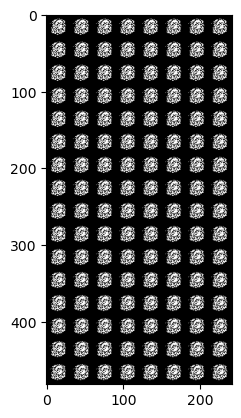

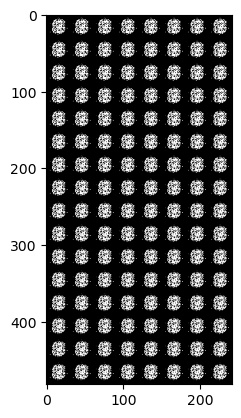

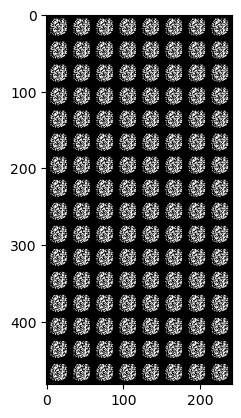

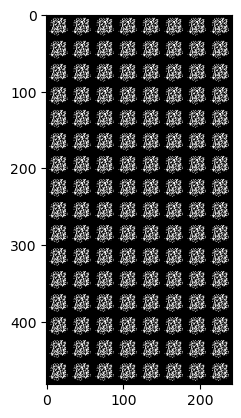

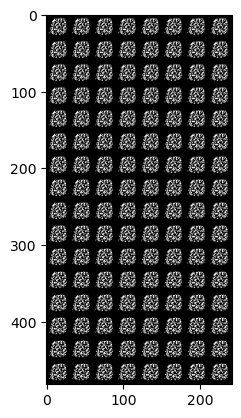

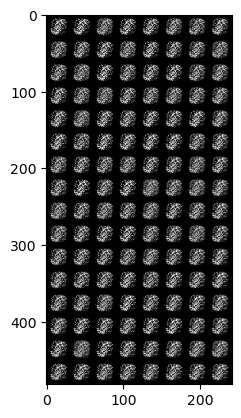

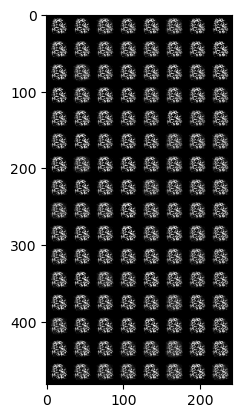

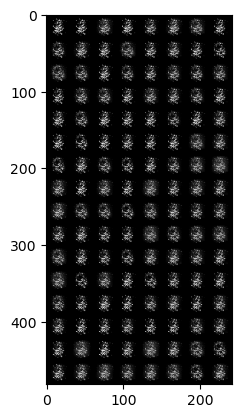

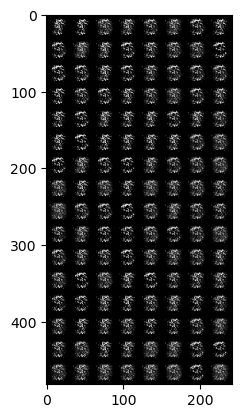

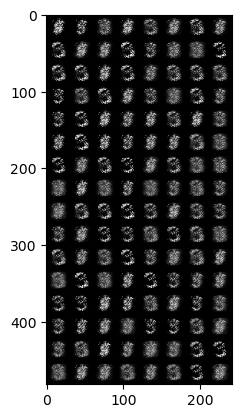

In [14]:
plot_gif(training_progress_images_list)